In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from IPython.core.display import HTML
HTML("<style>.container { width:100% !important; }</style>")

In [3]:
from KuhnPoker import KuhnPokerModel, KuhnPokerInfoSet, ActionNode, PASS, ADD_CHIP, Card, TensorModel, SamplingNode
from ISMCTS import Tree, Constants
from AlphaZero import NNModel, SelfPlayDataV, SelfPlayDataP, AlphaZero
from TreeVisualizer import plot_trees

import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from utils import get_max_model_number
import json


import os
from typing import List, Tuple
import ipywidgets as widgets
from IPython.display import display

np.set_printoptions(precision=2)

In [11]:
def load_models(directory) -> Tuple[List[nn.Module], List[nn.Module]]:
    max_vmodel = get_max_model_number(f'{directory}/vmodel')
    max_pmodel = get_max_model_number(f'{directory}/pmodel')
    
    assert max_vmodel == max_pmodel
    
    vmodel = []
    pmodel = []
    
    print('load models')
    for i in tqdm(range(max_vmodel + 1)):
        vmodel.append(torch.load(f'{directory}/vmodel/vmodel-{i}.pt'))
        pmodel.append(torch.load(f'{directory}/pmodel/pmodel-{i}.pt'))
    
    return vmodel, pmodel

def make_df(vmodel: List[nn.Module], pmodel: List[nn.Module]):
    p_info_set = KuhnPokerInfoSet([0], [None, Card.JACK])
    q_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, None])
    j01_info_set = KuhnPokerInfoSet([0, 1], [None, Card.JACK])
    kj01_info_set = KuhnPokerInfoSet([0, 1], [Card.KING, Card.JACK])
    qj01_info_set = KuhnPokerInfoSet([0, 1], [Card.QUEEN, Card.JACK])
    
    jo_info_set = KuhnPokerInfoSet([], [Card.JACK, None])
    qo_info_set = KuhnPokerInfoSet([], [Card.QUEEN, None])
    ko_info_set = KuhnPokerInfoSet([], [Card.KING, None])
    
    
    ko01_info_set = KuhnPokerInfoSet([0, 1], [Card.KING, None])
    
    
    ps = []
    qs = []
    vs = []
    vs1 = []
    vs2 = []
    
    jo = []
    qo = []
    ko = []
    
    
    ko01 = []

    for i in tqdm(range(len(vmodel))):
        p = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(p_info_set))[1]
        q = TensorModel(vmodel[i], pmodel[i]).eval_P(ActionNode(q_info_set))[1]

        v, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(SamplingNode(j01_info_set))

        kj_node = ActionNode(kj01_info_set)
        kj_node.spawned_tree = 1
        v1, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(kj_node)

        qj_node = ActionNode(qj01_info_set)
        qj_node.spawned_tree = 1
        v2, _ = TensorModel(vmodel[i], pmodel[i]).eval_V(qj_node)
        
        ps.append(p)
        qs.append(q)
        vs.append(v)
        vs1.append(v1)
        vs2.append(v2)
        
        # Alice's first move
        jo.append(TensorModel(vmodel[i], pmodel[i], learn_trivial=True).eval_P(ActionNode(jo_info_set))[1])
        qo.append(TensorModel(vmodel[i], pmodel[i], learn_trivial=True).eval_P(ActionNode(qo_info_set))[1])
        ko.append(TensorModel(vmodel[i], pmodel[i], learn_trivial=True).eval_P(ActionNode(ko_info_set))[1])
        
        # Alice's move on Bob bets
        ko01.append(TensorModel(vmodel[i], pmodel[i], learn_trivial=True).eval_P(ActionNode(ko01_info_set))[1])
        
    df = pd.DataFrame({'p': ps, 'q': qs, 'v_?J[01]': vs, 'v_KJ[01]': vs1, 'v_QJ[01]': vs2, 
                       'J?[]': jo, 'Q?[]': qo, 'K?[]': ko,
                       'K?[01]': ko01})
    
    return df

def load_model_df(directory):
    vmodel, pmodel = load_models(directory)
    return make_df(vmodel, pmodel)

def compute_sample_pq(positions):
    data = []
    for pos in tqdm(positions):
        if pos.policy_target is not None:
            cards = [getattr(c, 'value', -1) for c in pos.info_set.cards]

            data.append([pos.info_set.action_history,
                       cards,
                       pos.policy_target[1],
                       pos.gen_id,
                      ])
    df = pd.DataFrame(data, columns=['action_history', 'cards', 'policy', 'gen_id'])

    p_ix = df['action_history'].apply(lambda x: x == [0]) & df['cards'].apply(lambda x: x == [-1, 0])
    q_ix = df['action_history'].apply(lambda x: x == [0, 1]) & df['cards'].apply(lambda x: x == [1, -1])
    
    # Alice's first move
    jo_ix = df['action_history'].apply(lambda x: x == []) & df['cards'].apply(lambda x: x == [0, -1])
    qo_ix = df['action_history'].apply(lambda x: x == []) & df['cards'].apply(lambda x: x == [1, -1])
    ko_ix = df['action_history'].apply(lambda x: x == []) & df['cards'].apply(lambda x: x == [2, -1])
    
    
    ko01_ix = df['action_history'].apply(lambda x: x == [0, 1]) & df['cards'].apply(lambda x: x == [2, -1])

    p_hat = df[p_ix].groupby('gen_id')['policy'].mean()
    q_hat = df[q_ix].groupby('gen_id')['policy'].mean()
    
    # Alice's first move
    jo_hat = df[jo_ix].groupby('gen_id')['policy'].mean()
    qo_hat = df[qo_ix].groupby('gen_id')['policy'].mean()
    ko_hat = df[ko_ix].groupby('gen_id')['policy'].mean()
    
    ko01_hat = df[ko01_ix].groupby('gen_id')['policy'].mean()
    
    return p_hat, q_hat, jo_hat, qo_hat, ko_hat, ko01_hat

def plot_pq_traj(df_model):
    data = df_model

    plt.figure(figsize=(8, 6)) 
    plt.plot(data['p'], data['q'], linestyle='-', color='b', alpha=0.5)
    plt.title('Trajectory in p-q Space') 
    plt.xlabel('p')  
    plt.ylabel('q') 
    plt.grid(True) 


    # Annotate every 32nd point with its order number
    for i, (p, q) in enumerate(zip(data['p'], data['q'])):
        if i % 64 == 0:
            plt.text(p, q, str(i), color="red", fontsize=12)

    # Mark the last point with a special marker
    plt.scatter(data['p'].iloc[-1], data['q'].iloc[-1], color='red', s=100, marker='o', label='Last Point')

    # Marking the target point
    plt.scatter([1/3], [1/3], color='green', s=100, marker='x', label='Target (1/3, 1/3)')

def plot_v(df_model):
    plt.figure(figsize=(10, 8))
    plt.plot(df_model.index, df_model['v_?J[01]'], label='v_?J[01]')
    plt.plot(df_model.index, df_model['v_KJ[01]'], label='v_KJ[01]')
    plt.plot(df_model.index, df_model['v_QJ[01]'], label='v_QJ[01]')

    plt.axhline(y=-1, color='blue', linestyle='--')
    plt.axhline(y=-2, color='orange', linestyle='--')
    plt.axhline(y=0, color='green', linestyle='--')


    plt.legend()
    plt.title('V')

    
def plot_self_play(df_model, positions):
    p_hat, q_hat, _, _, _, _ = compute_sample_pq(positions)

    plt.figure(figsize=(10, 8))
    plt.plot(p_hat.index, p_hat,'x', color='green', label='p_hat', alpha=0.5)
    plt.plot(q_hat.index, q_hat, '+', color = 'orange', label='q_hat', alpha=0.5)
    plt.plot(df_model.index, df_model['p'], 'o', markersize=4, color='blue', label='p', alpha=0.3)
    plt.plot(df_model.index, df_model['q'], '^', markersize=4, color='red', label='q', alpha=0.3)
    plt.axhline(y=1/3, color='r', linestyle='--')
    plt.legend()
    plt.title('p, q N-dist')
    
def plot_trivial_first(df_model, positions):
    _, _, jo_hat, qo_hat, ko_hat, _ = compute_sample_pq(positions)

    plt.figure(figsize=(10, 8))
    
    # Alice's first move in self-play data
    plt.plot(jo_hat.index, jo_hat,'x', color='brown', label='J?[] hat', alpha=1)
    plt.plot(qo_hat.index, qo_hat,'x', color='green', label='Q?[] hat', alpha=1)
    plt.plot(ko_hat.index, ko_hat,'x', color='orange', label='K?[] hat', alpha=1)
    
#     plt.plot(ko01_hat.index, ko01_hat,'x', color='orange', label='K?[01] hat', alpha=1)

    # Alice's first move in model
    plt.plot(df_model.index, df_model['J?[]'], 'o', markersize=4, color='purple', label='J?[]', alpha=0.3)
    plt.plot(df_model.index, df_model['Q?[]'], 'o', markersize=4, color='blue', label='Q?[]', alpha=0.3)
    plt.plot(df_model.index, df_model['K?[]'], 'o', markersize=4, color='red', label='K?[]', alpha=0.3)
    
    print(f"J?[]: {df_model.loc[df_model.index[-1], 'J?[]']}, Q?[]: {df_model.loc[df_model.index[-1], 'Q?[]']}, K?[]: {df_model.loc[df_model.index[-1], 'K?[]']}")
    
    
#     plt.plot(df_model.index, df_model['K?[01]'], '^', markersize=4, color='red', label='K?[01]', alpha=0.3)
    
    plt.axhline(y=1.0, color='red', linestyle='--')
    plt.axhline(y=0.0, color='blue', linestyle='--')
    
    plt.legend()
    plt.title('trivial moves')
    
    
def plot_std(df_model):
    plt.figure(figsize=(10, 8))
    plt.plot(df_model.index, df_model['p_std'], label='p_std')
    plt.plot(df_model.index, df_model['q_std'], label='q_std')

    plt.legend()
    plt.title('std')
    
def plot_exp_folder(folder):
    with open(f'{folder}/config.json', 'r') as f:
        config = json.load(f)

    for k, v in config.items():
        print(f'{k}: {v}')
        
    with open(f'{folder}/positions.pkl', 'rb') as f:
        positions = pickle.load(f)

    df_model = load_model_df(f'{folder}/')
    df_model['p_std'] = df_model['p'].rolling(window=500).std()
    df_model['q_std'] = df_model['q'].rolling(window=500).std()
    
    plot_pq_traj(df_model)
    plot_v(df_model)
    plot_self_play(df_model, positions)
    plot_std(df_model)
    plot_trivial_first(df_model, positions)

In [ ]:
with open(f'exp_trivial2/positions.pkl', 'rb') as f:
    positions = pickle.load(f)
    
data = []
for pos in tqdm(positions):
    if pos.policy_target is not None:
        cards = [getattr(c, 'value', -1) for c in pos.info_set.cards]

        data.append([pos.info_set.action_history,
                   cards,
                   pos.policy_target[1],
                   pos.gen_id,
                  ])
        
df = pd.DataFrame(data, columns=['action_history', 'cards', 'policy', 'gen_id'])

In [ ]:
df = pd.DataFrame(positions)

In [ ]:
df.groupby('gen_id').count()

In [ ]:
len(df)

In [ ]:
df.iloc[300000]

In [ ]:
df[(df['action_history'].apply(lambda x: x == [0])) & (df['gen_id'] == 220)]

In [ ]:
plot_exp_folder('example')

In [ ]:
plot_exp_folder('exp1')

In [ ]:
plot_exp_folder('exp2')

In [ ]:
plot_exp_folder('exp3')

In [ ]:
plot_exp_folder('exp_trivial')

In [ ]:
plot_exp_folder('exp_trivial2')

load_and_resume: True
learn_trivial: True
iter: 1000
eps: 0.0
c_PUCT: 1.0
Dirichlet_ALPHA: 0.1
buffer: 0
num_gens: 10000
num_games_per_gen: 32
processes: 8
load models


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6011/6011 [00:05<00:00, 1052.33it/s]


<IPython.core.display.Javascript object>


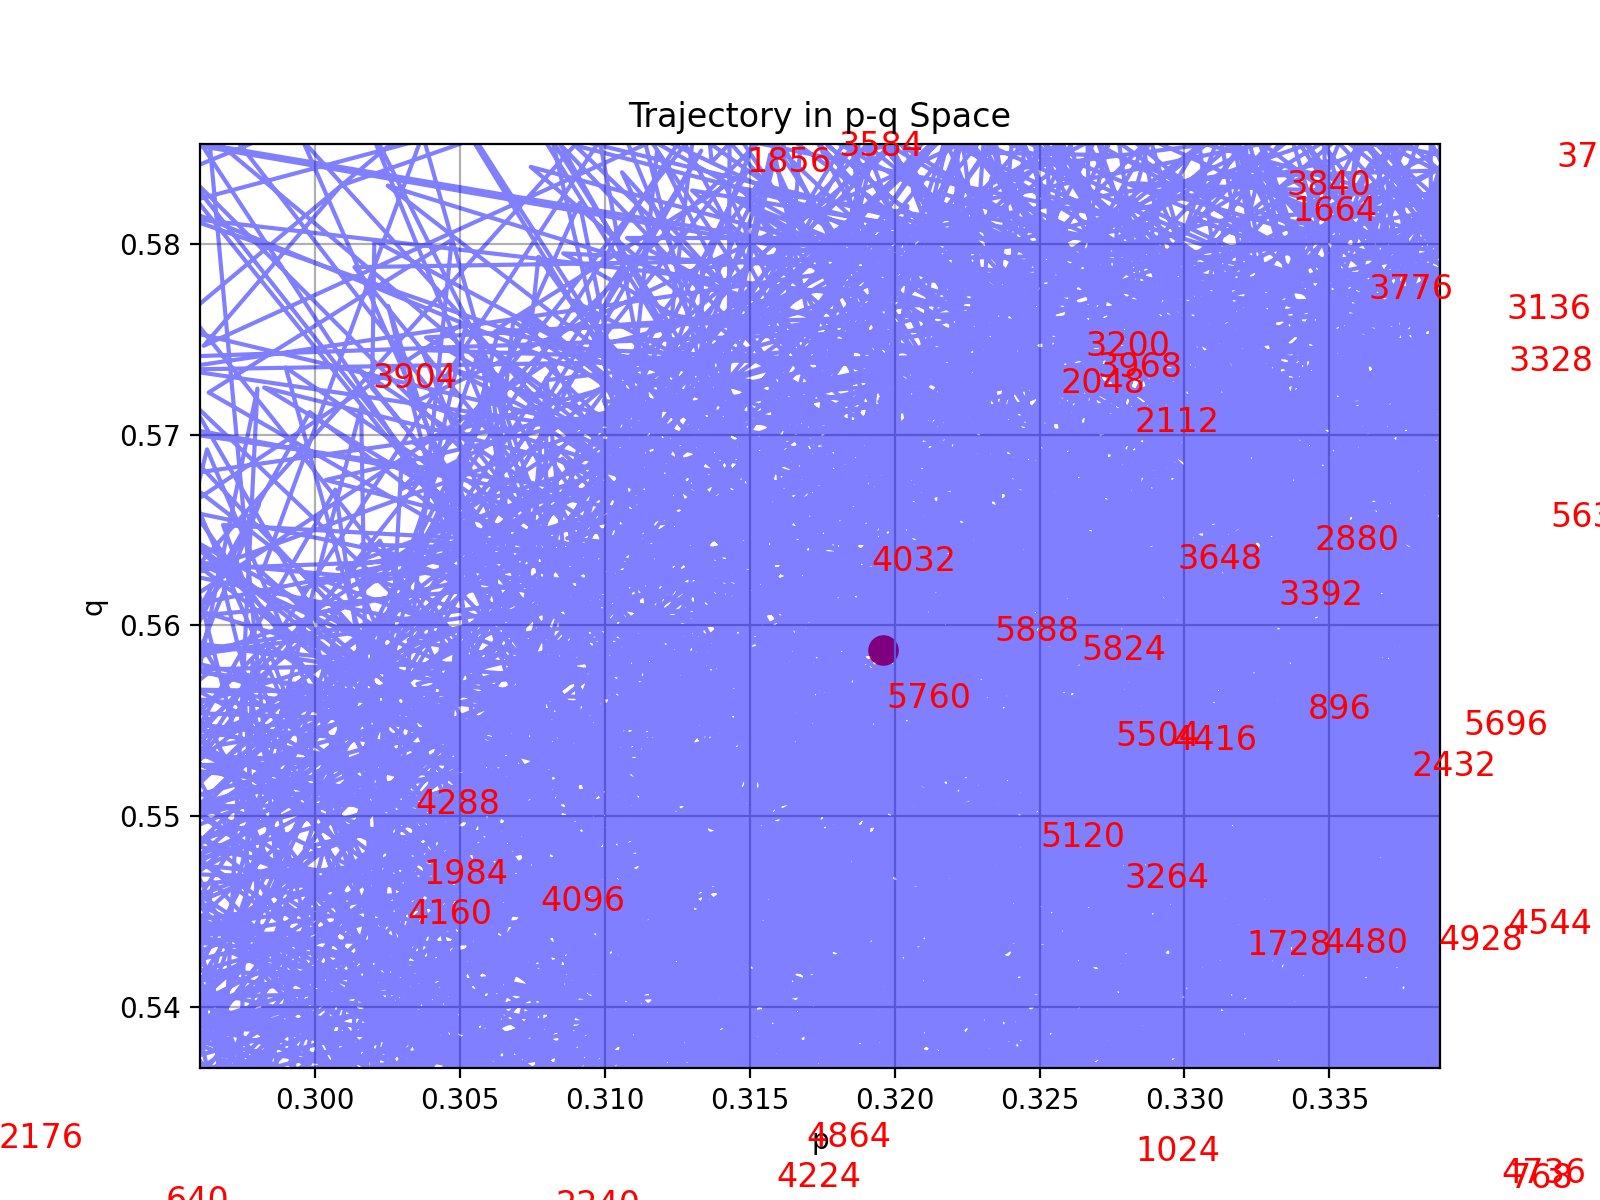

<IPython.core.display.Javascript object>


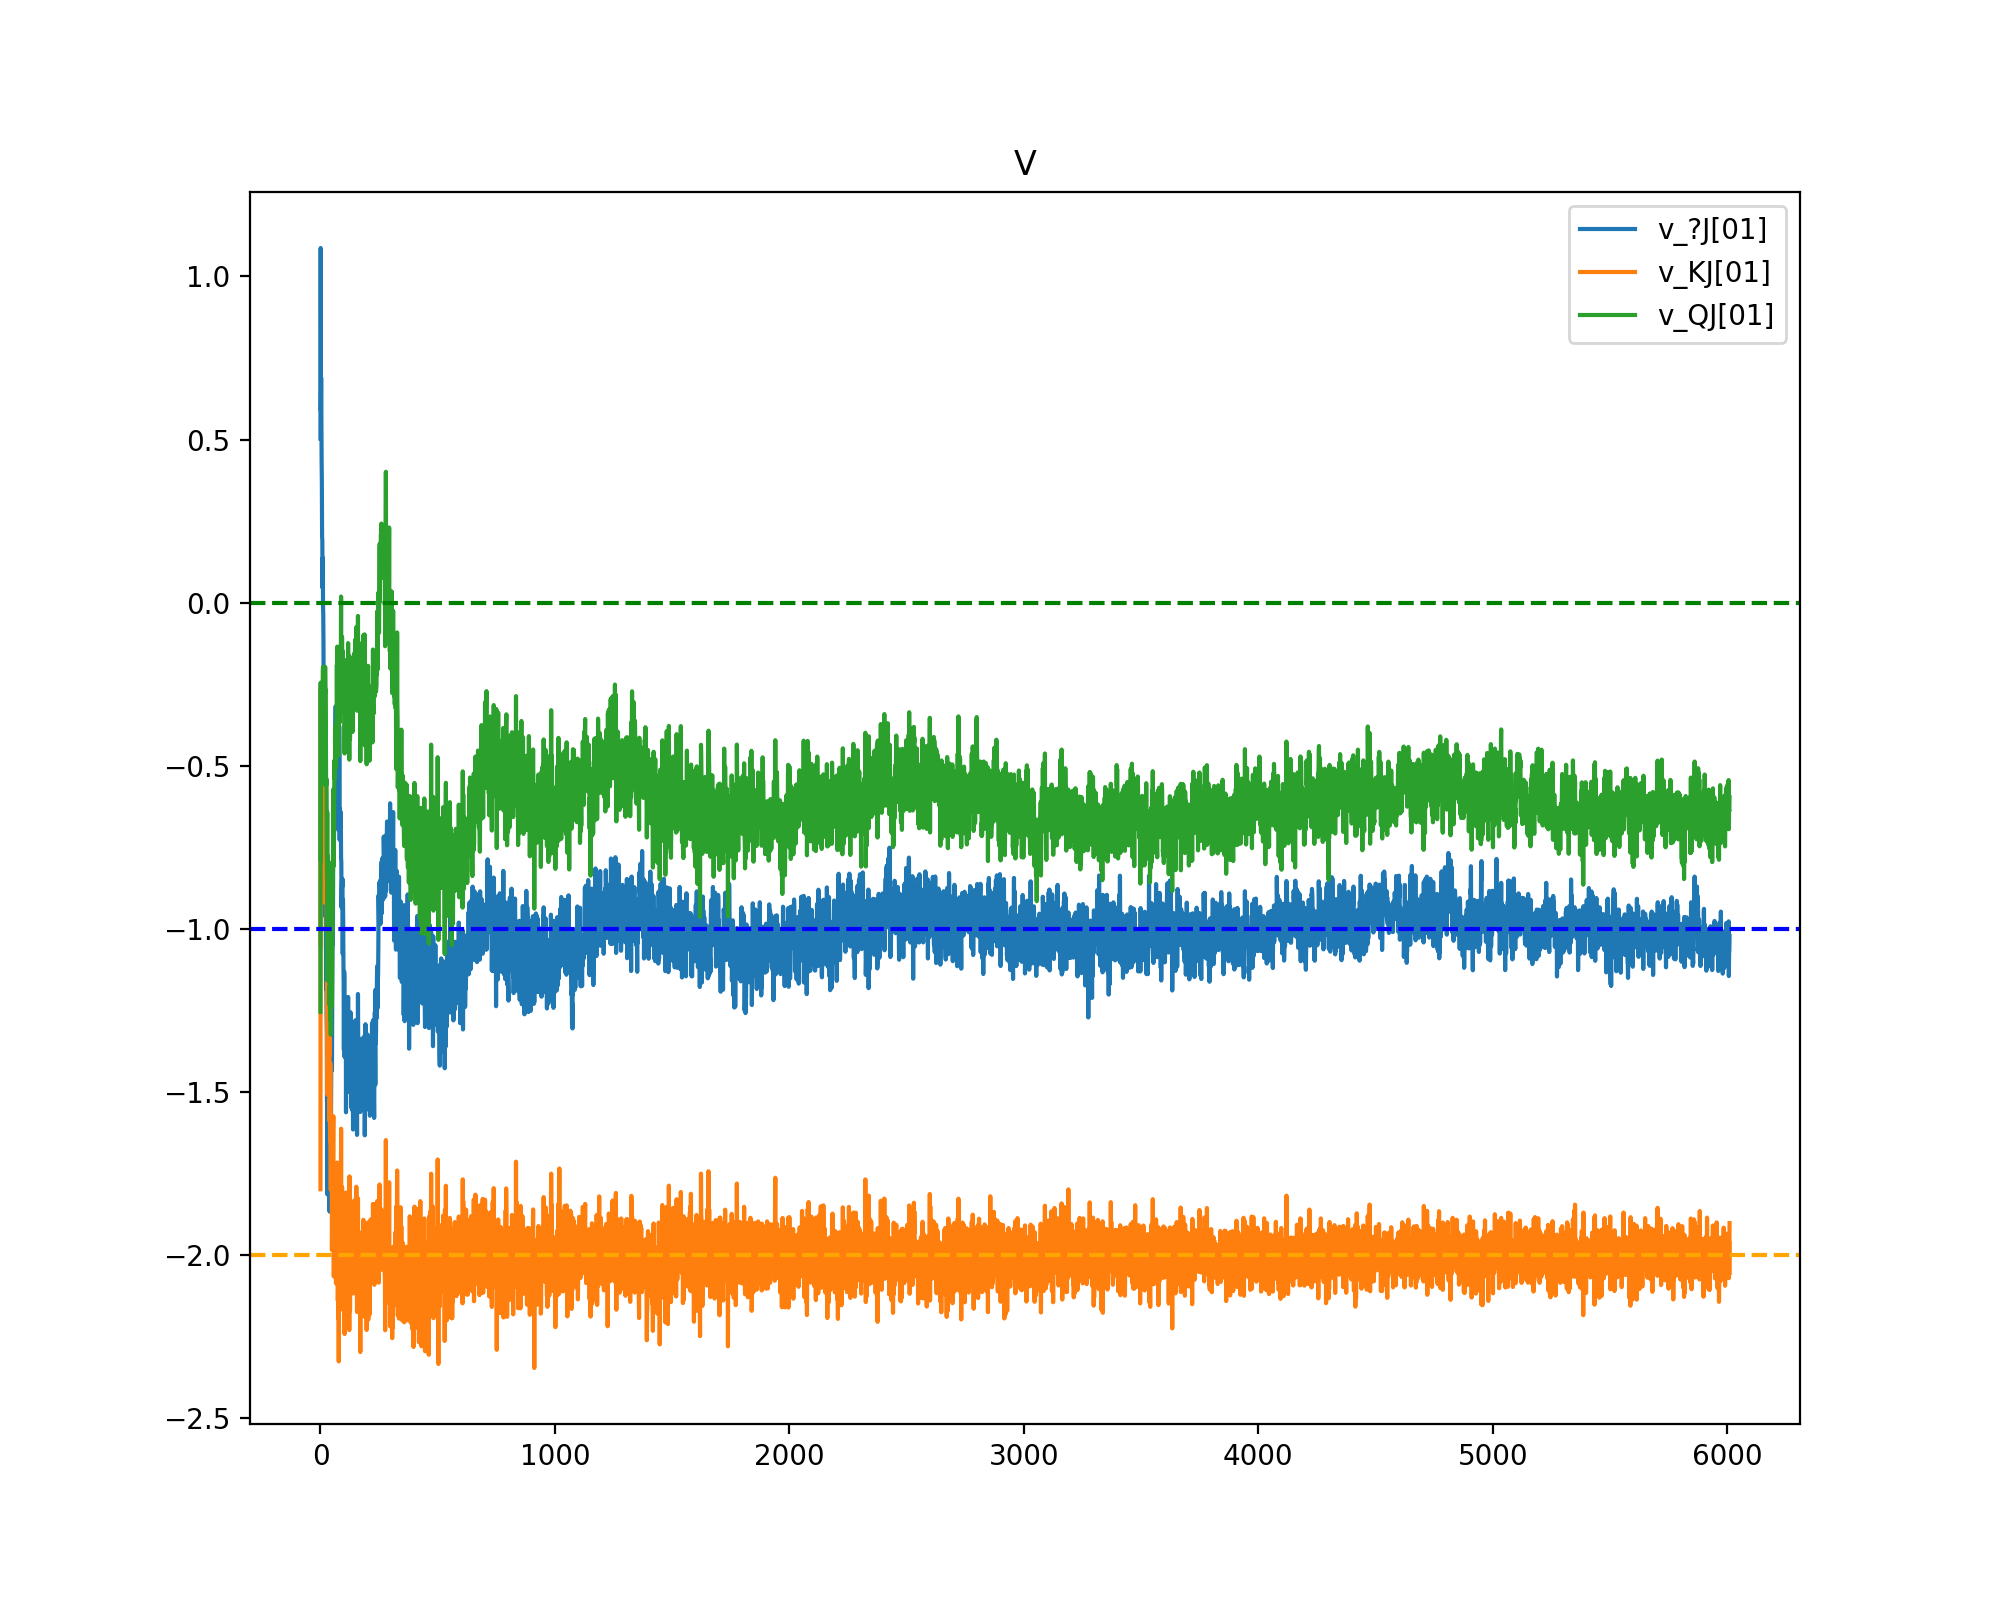

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1745509/1745509 [00:00<00:00, 2792457.55it/s]


<IPython.core.display.Javascript object>


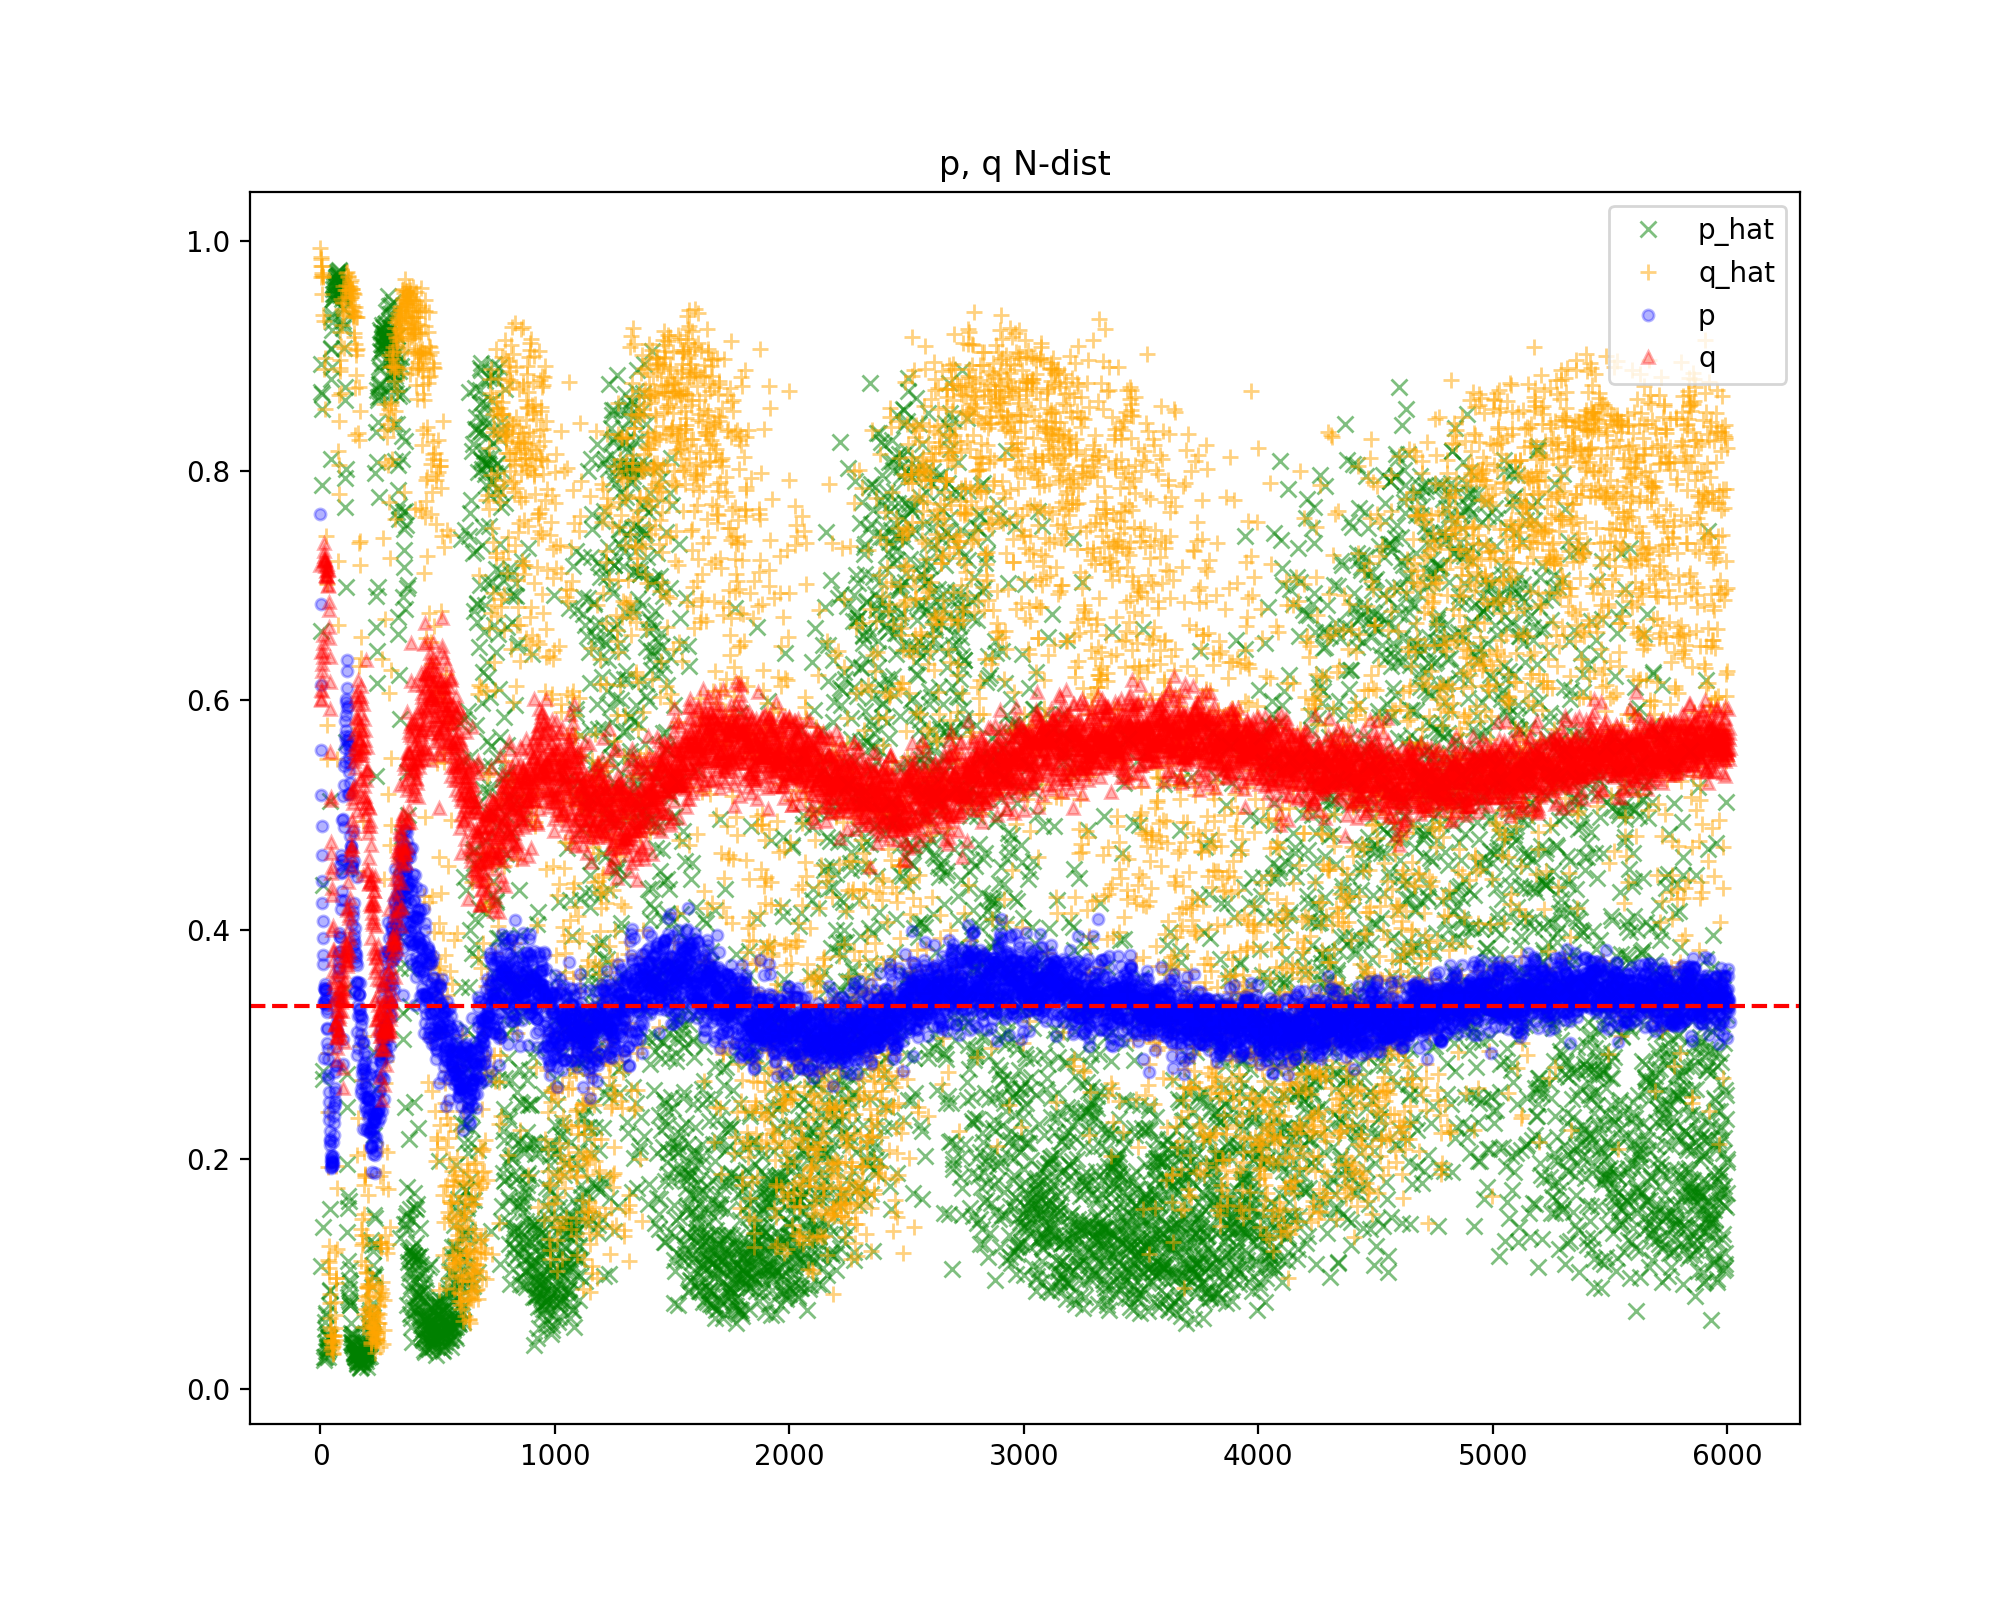

<IPython.core.display.Javascript object>


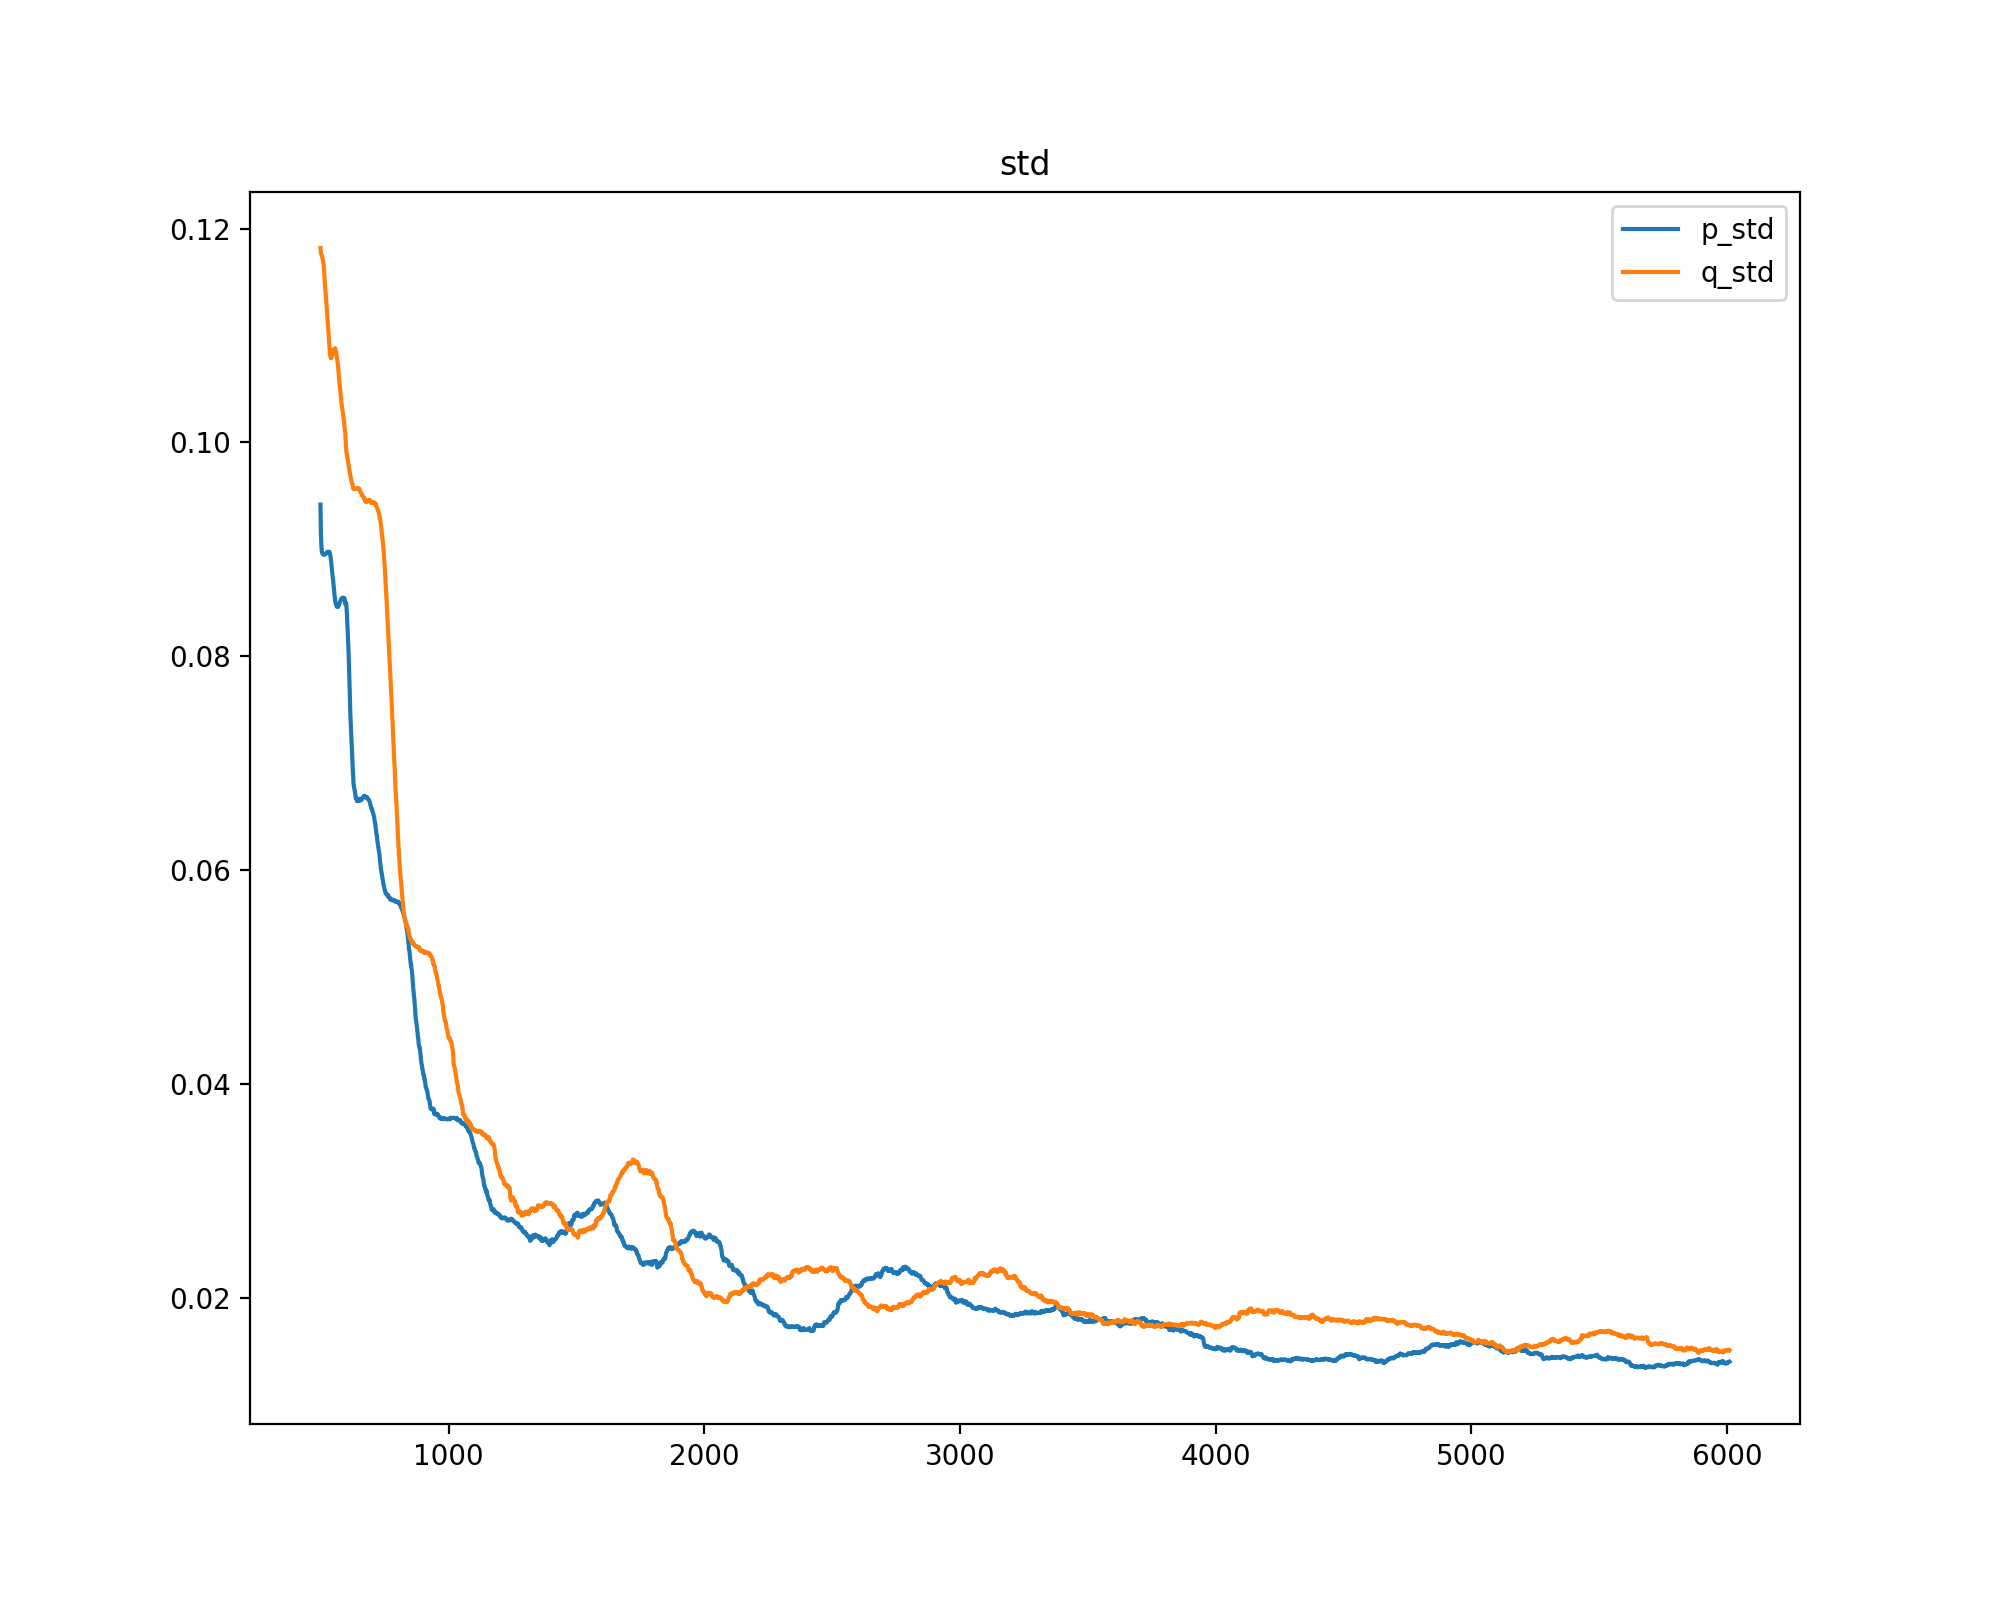

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1745509/1745509 [00:00<00:00, 2823114.98it/s]


<IPython.core.display.Javascript object>


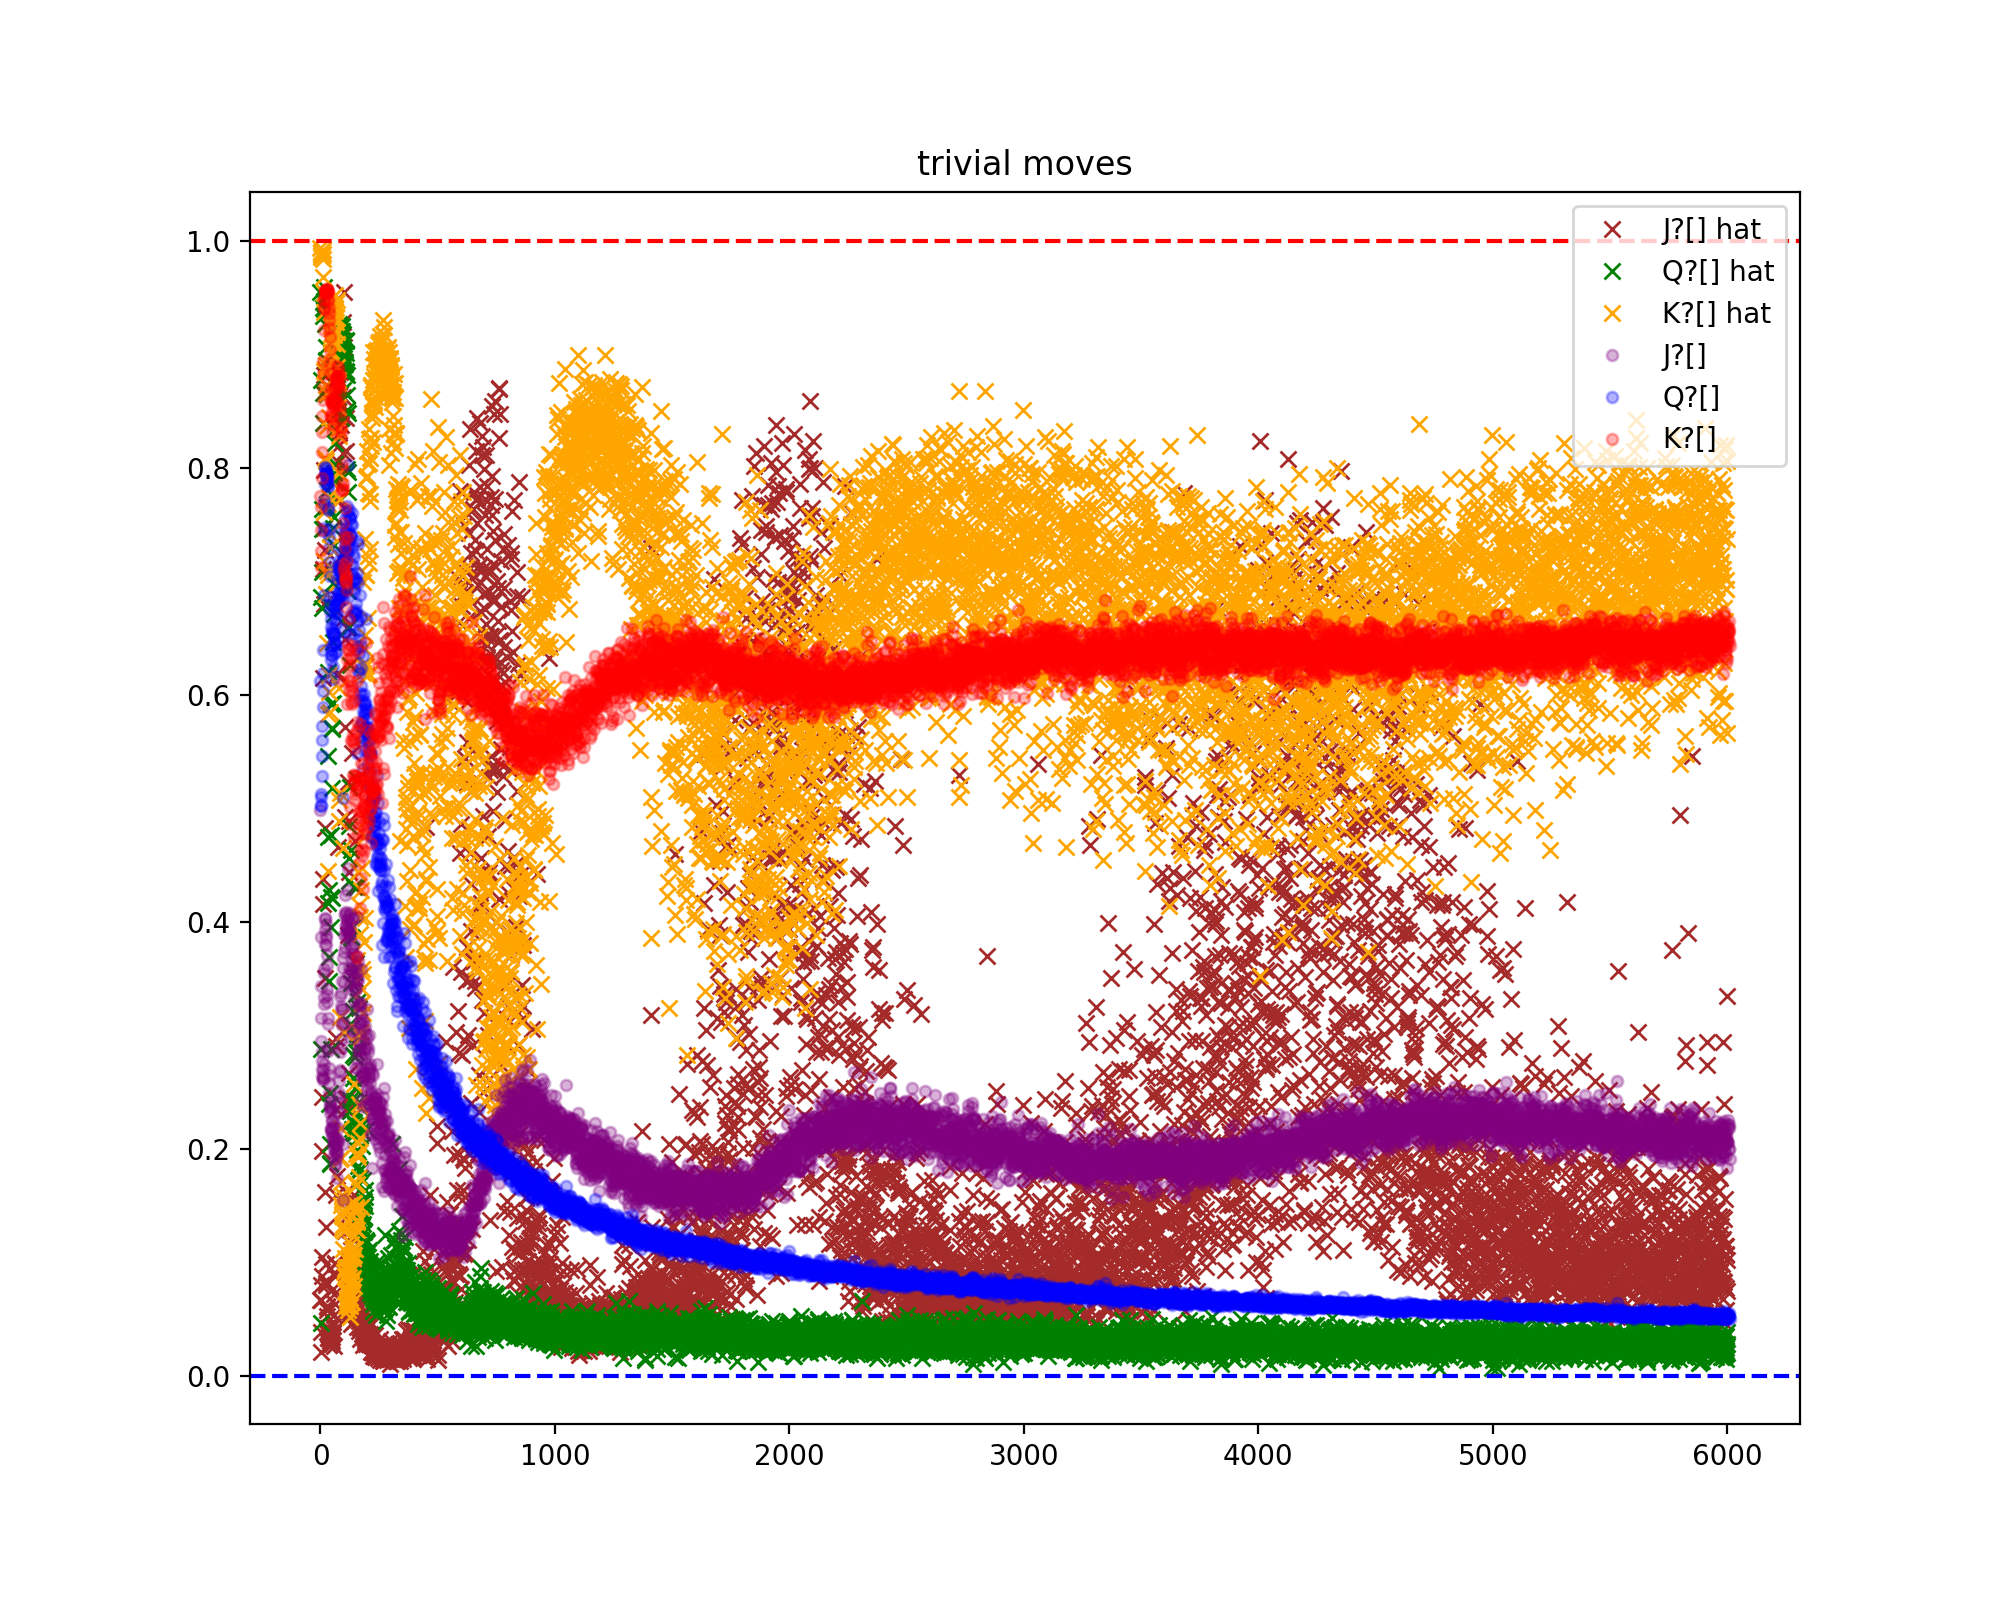

J?[]: 0.19149306416511536, Q?[]: 0.04982858523726463, K?[]: 0.6431729793548584


In [12]:
plot_exp_folder('exp_trivial3')